<a href="https://colab.research.google.com/github/nsn20/bert/blob/main/BERT_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install praw

In [2]:
import tensorflow as tf
import pandas as pd
import praw
from transformers import TFAutoModelForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt 

In [3]:
model = TFAutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing TFBertForTokenClassification: ['dropout_147']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english and are newly initialized: ['dropout_73']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
reddit = praw.Reddit(client_id = 'ovi9op7w_9iWOw',
                     client_secret = 'gy3r8s4J5gw8b6jlu3doZUZoc9f0GA',
                     user_agent = 'bert')
science = reddit.subreddit('science')

In [5]:
label_list = ["O","B-MISC","I-MISC","B-PER","I-PER","B-ORG","I-ORG","B-LOC","I-LOC"]
categories = {'I-LOC': [], 'I-ORG': [], 'I-PER': [], 'B-LOC': [], 'B-ORG': [], 'B-PER': []}
temp = ''
current = ''
old_tag = ''

In [6]:
def reply(top_comment, comment_list):
    if len(top_comment.replies) == 0:
        return
    else:
        for num, comment in enumerate(top_comment.replies):
            try:
                comment_list.append(str(comment.body))
            except:
                continue
            reply(comment, comment_list)

In [7]:

top = science.top('year', limit=1)
comments = [] 
for submission in top:
    submission_comm = reddit.submission(id=submission.id)
    comments.append(str(submission.title))
    for count, top_comment in enumerate(submission_comm.comments):
        try:
            reply(top_comment, comments)
        except:
            continue

In [8]:


for sequence in comments:
    if len(sequence) > 512:
        continue

    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
    inputs = tokenizer.encode(sequence, return_tensors="tf")
    outputs = model(inputs)[0]
    predictions = tf.argmax(outputs, axis=2)
    

    result = [(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].numpy())]
    for i in result:
        if i[1] in ['O', 'B-MISC', 'I-MISC']:
            if len(current) > 0:
                stripped_word = temp.strip()
                if len(stripped_word) > 1:
                    categories[current].append(stripped_word)
            temp = ''
            current = ''
            continue
        else:
            current = i[1]

            if old_tag != current and len(old_tag) > 0:
                stripped_word = temp.strip()
                if len(stripped_word) > 1:
                    categories[old_tag].append(stripped_word)
                temp = ''
                current = ''

            if i[0].startswith('##'): 
                temp += i[0][2:].upper()
            elif i[1] in ['I-PER', 'I-ORG', 'I-LOC', 'B-LOC', 'B-ORG', 'B-PER']:
                temp += " " + i[0].upper()
                current = i[1]
            old_tag = current



In [9]:
words = list(categories['I-LOC'] + categories['B-LOC'] + categories['I-ORG'] + categories['B-ORG'] + categories['I-PER'] + categories['B-PER'])
print(words)
word_count = {}
for word in words:
  if word not in word_count:
    word_count[word] = 1
  else:
    word_count[word] += 1
print(word_count)
keyword = dict((k, v) for k, v in word_count.items() if v >= 2)

['US', 'US', 'SILICON VALLEY', 'BOSTON', 'RALEIGH', 'NC', 'PITTSBURGH', 'MIDWEST', 'CALIFORNIA', 'USA', 'TEXAS', 'US', 'EUROPE', 'US', 'US', 'US', 'SWITZERLAND', 'US', 'CHICAGO', 'ILLINOIS', 'TEXAS', 'TEXAS', 'ATLANTA', 'GEORGIA', 'GEORGIA', 'PENNSYLVANIA', 'TEXAS', 'PA', 'ATLANTA', 'SAVANNAH', 'SAVANNAH', 'TEXAS', 'NEW YORK CITY', 'CALIFORNIA', 'OREGON', 'TEXAS', 'LA JOLLA', 'CANADA', 'NORWAY', 'UNITED STATES', 'AMERICA', 'CA', 'USA', 'SWITZERLAND', 'CANTON', 'VERMONT', 'AMERICA', 'NORWAY', 'US', 'AMERICA', 'CANADA', 'RUSSIA', 'AMERICA', 'CANADA', 'CALIFORNIA', 'US', 'UNITED STATES', 'AMERICA', 'LAKE', 'US', 'USA', 'US', 'US', 'USA', 'US', 'US', 'SCANDINAVIA', 'STANFORD', 'UC', 'STANFORD', 'DUKE', 'UNC', 'NC STATE', 'BENZ', 'REDDIT', 'UOFA', 'ELA', 'BROWN', 'BOARD', 'MIC', 'ARMY', 'INFANTRY', 'ARMY', 'NAVY', 'AOC', 'OECD', 'DUNLAP CUSD', 'EORIA PUBLIC', 'TEXAS MONTHLY', 'PUBLIC SCHOOLS', 'OP', 'GA', 'PT', 'AIG', 'AIG', 'AIG', 'US TREASURY', 'FANNIE AND FREDDIE', 'SSA', 'TREASURY', 'AI

Text(0.5, 1.0, 'Keywords part of the top post from the past year')

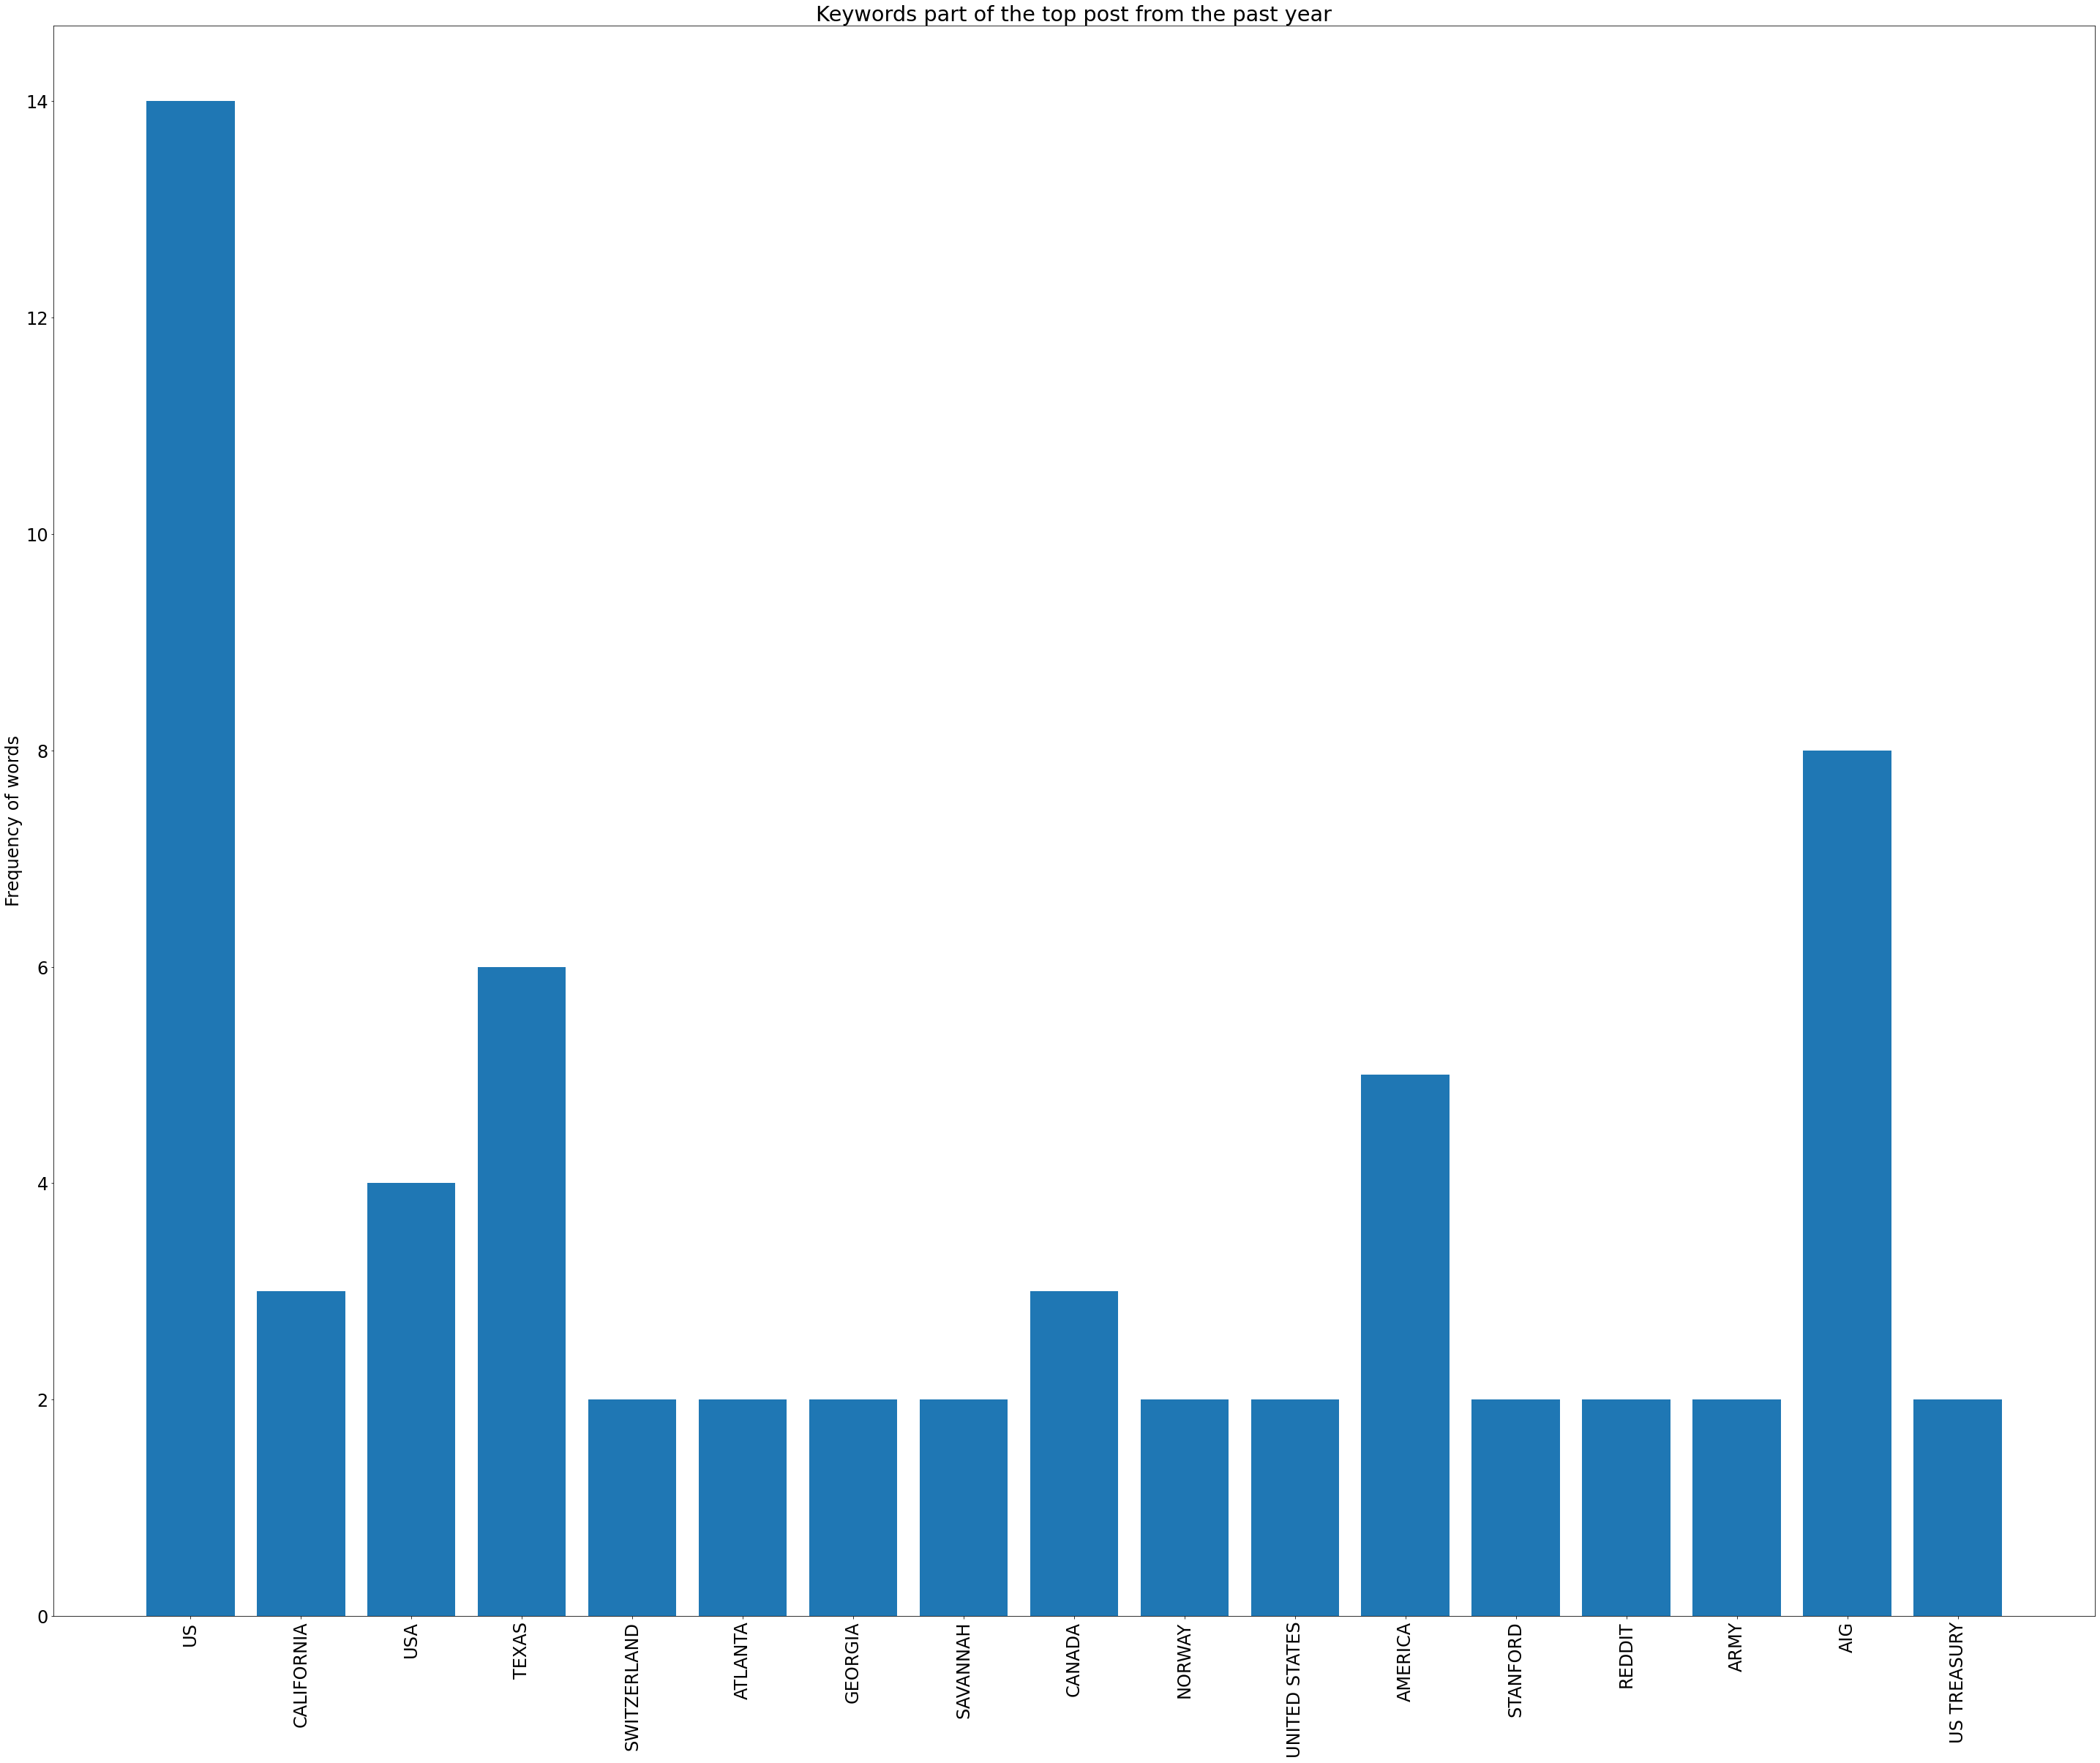

In [10]:
height = 40
width = 50
plt.figure(figsize=(width, height))
plt.rcParams.update({'font.size': 24})

plt.bar(range(len(keyword)), list(keyword.values()))
plt.xticks(range(len(keyword)), list(keyword.keys()), rotation = 90)
plt.ylabel("Frequency of words")
plt.title("Keywords part of the top post from the past year")

{'FERGUSON': 1, 'GLASS': 1, 'ST': 1, 'GALL': 1, 'TIMMY': 1, 'LITTLE TIMMY': 1, 'TRUMP': 1, 'MILTON FRIEDMAN': 1, 'REAGAN': 1, 'B CLINTON': 1}


Text(0.5, 1.0, 'Names')

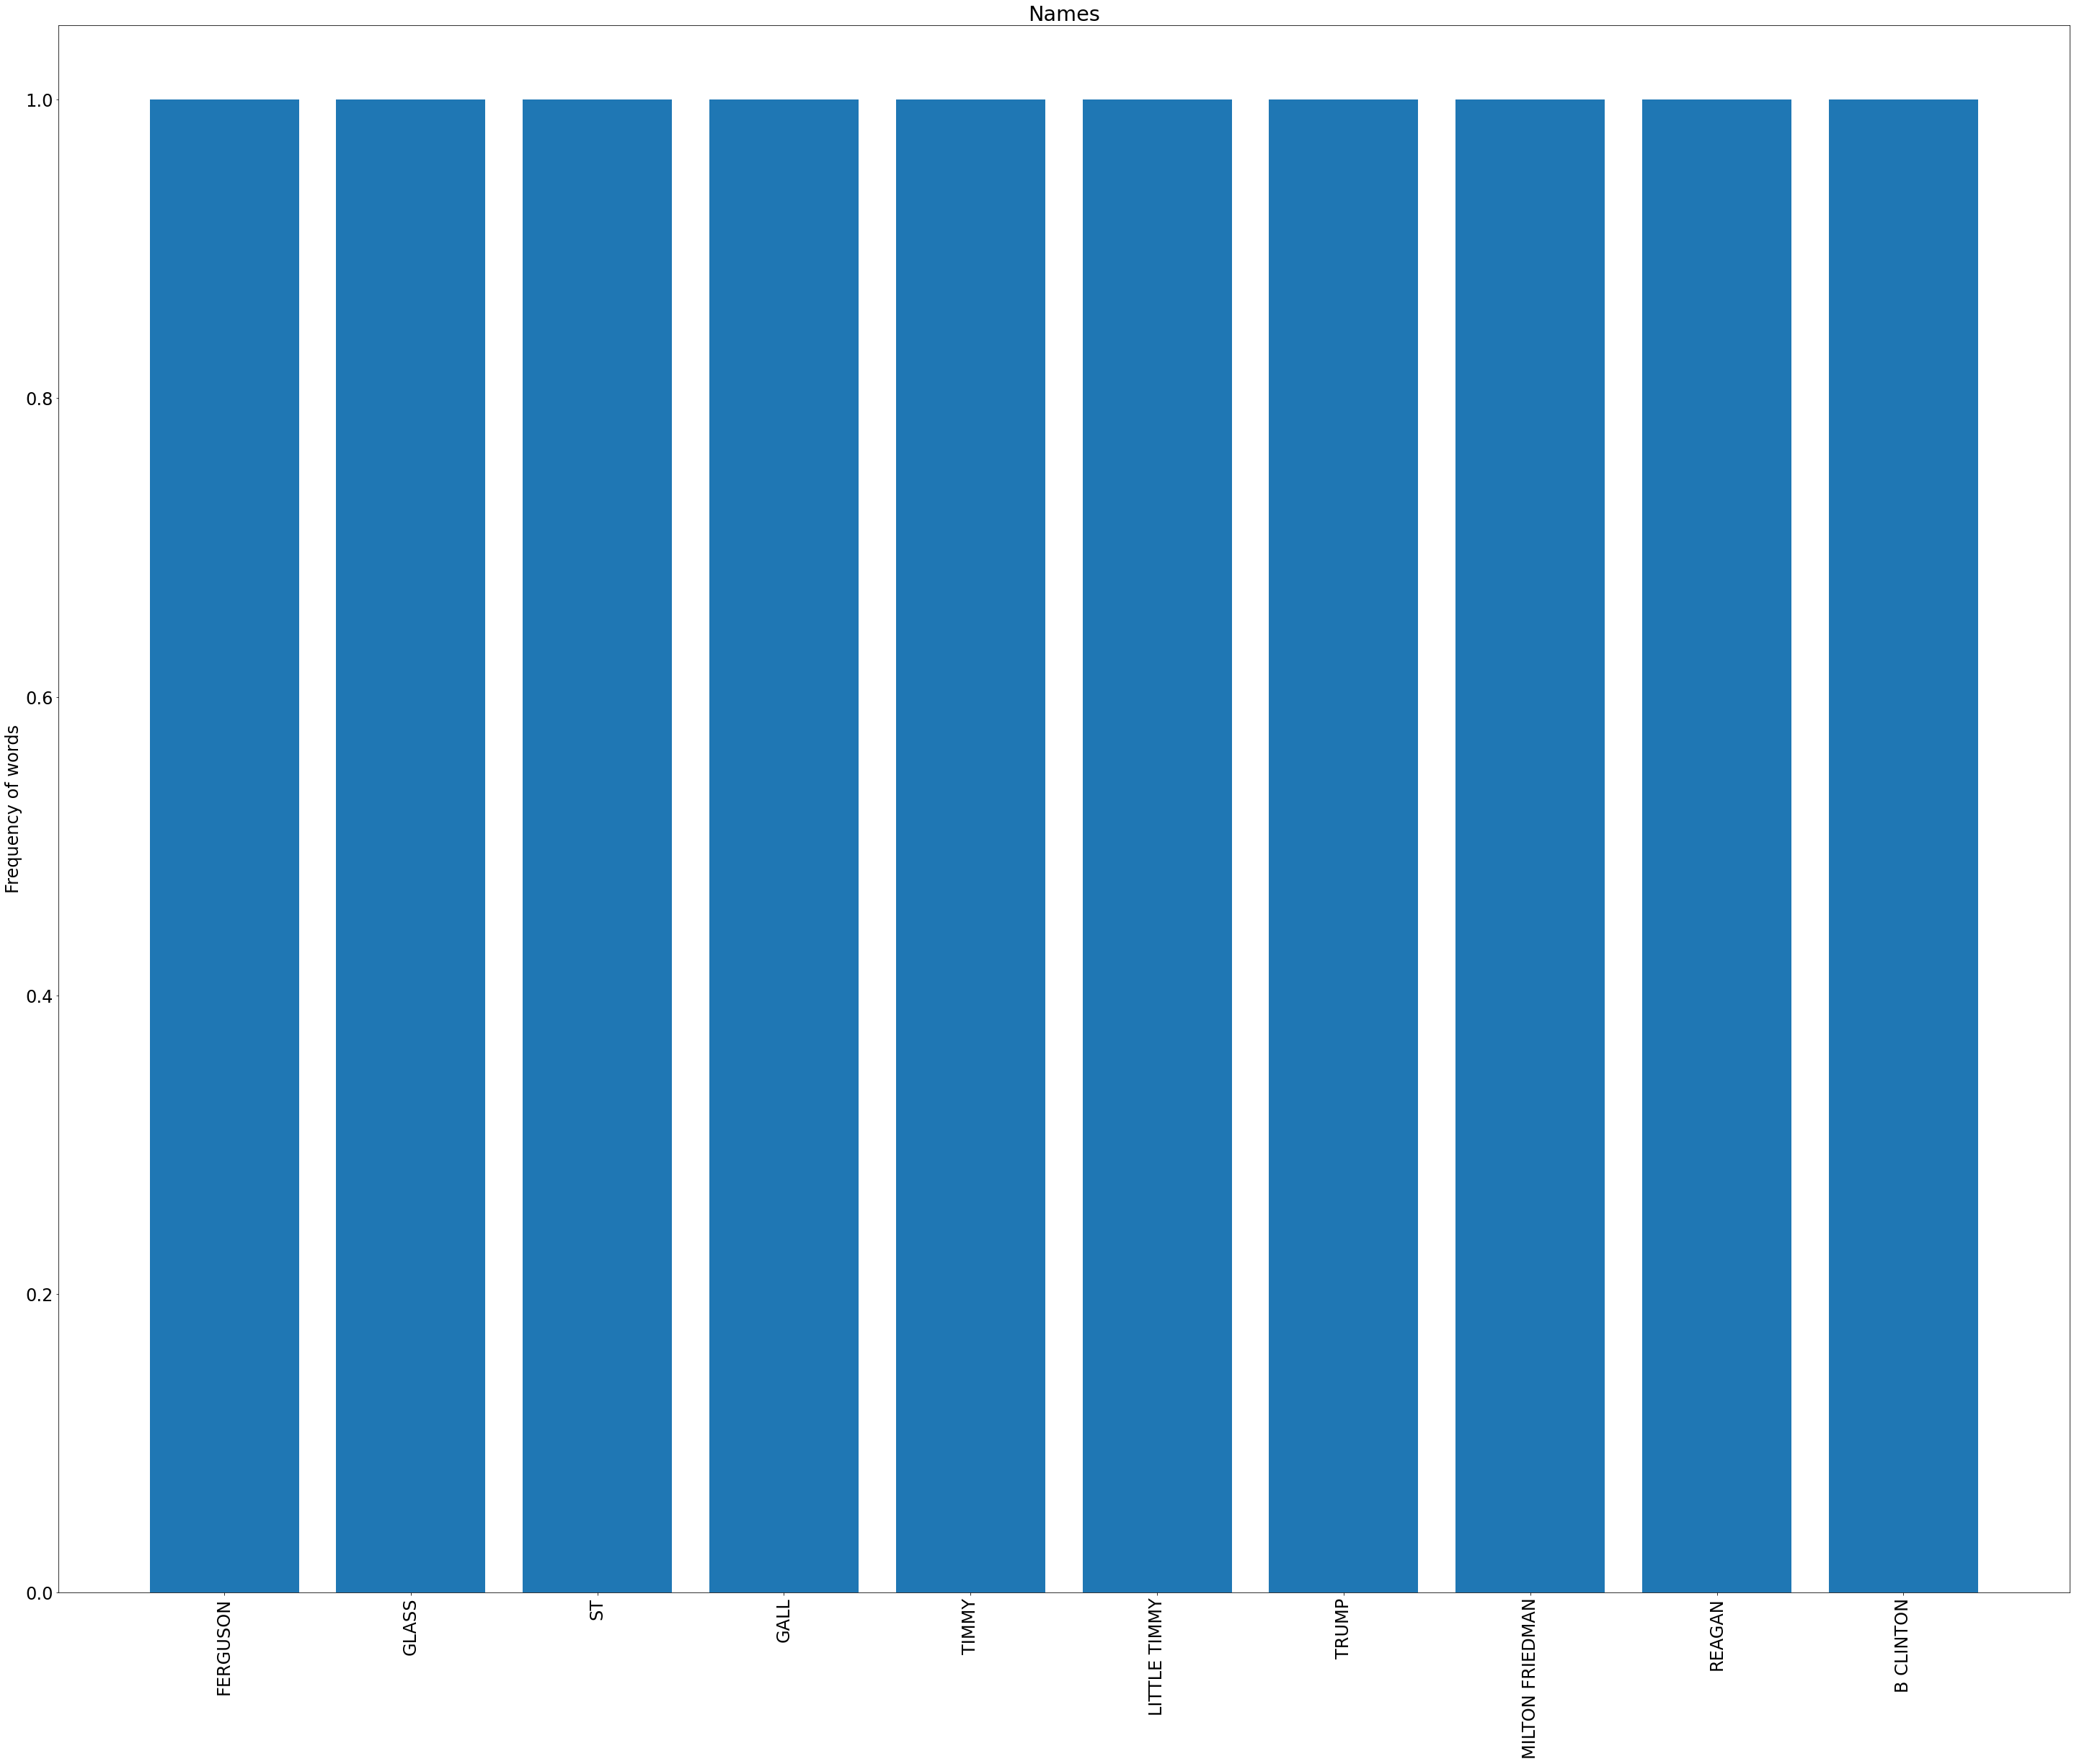

In [11]:
names = list(categories['I-PER'] + categories['B-PER'])
word_count = {}
for name in names:
  if name not in word_count:
    word_count[name] = 1
  else:
    word_count[name] += 1

print(word_count)

height = 40
width = 50
plt.figure(figsize=(width, height))
plt.rcParams.update({'font.size': 24})

plt.bar(range(len(word_count)), list(word_count.values()))
plt.xticks(range(len(word_count)), list(word_count.keys()), rotation = 90)
plt.ylabel("Frequency of words")
plt.title("Names")